# Initialization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os, sys, time
import joblib

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, matthews_corrcoef

import scipy.stats
from warnings import simplefilter
from category_encoders import TargetEncoder

# Ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Specify database file location
#db_filename = 'filepath'

# Determine file location for objects to be saved
#cat_imputer_filename = 'filepath'
#num_imputer_filename = 'filepath'
#scaler_filename = 'filepath'
#encoder_filename = 'filepath'

# Specify database file location
db_filename = 'C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/Grade3ModelDBFinalOriginalPublish2.xlsx'

# Determine file location for objects to be saved
cat_imputer_filename = 'C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/categorical'
num_imputer_filename = 'C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/numerical'
scaler_filename = 'C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/scaler'
encoder_filename = 'C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/encoder'

In [3]:
# Read the excel file
df = pd.read_excel(db_filename)

In [4]:
# Features are going to be the X variables and the Toxicity Labels the Y variable
X_pre = df.iloc[:,:-1]
y = df.loc[:, ['Target']]

In [5]:
# Print Final DB Columns
X_pre.columns.tolist()

['Chemotherapy',
 'BMI',
 'Charlson',
 'KPS',
 'Ethnicity',
 'AgeAtCompletion',
 'TypeOfBoost',
 'TreatmentDays',
 'Applicator',
 'MRI',
 'V100',
 'D50',
 'D90',
 'D98',
 'D0.1Bladder',
 'D1Bladder',
 'D2Bladder',
 'D0.1SmallBowel',
 'D1SmallBowel',
 'D2SmallBowel',
 'D0.1Sigmoid',
 'D1Sigmoid',
 'D2Sigmoid',
 'D0.1Rectum',
 'D1Rectum',
 'D2Rectum',
 'TumorSite',
 'Stage',
 'Histology',
 'Size',
 'HRCTVolume',
 'FollowUp']

In [6]:
# Encoding values
encoding_dict = {
    'Chemotherapy': {'N': 0, 'Y': 1},
    'Charlson': {'Low': 0, 'Medium': 1, 'High': 2, 'VeryHigh': 3},
    'KPS': {'Good': 0, 'Normal': 1, 'Bad': 2},
    'Ethnicity': {'C': 0, 'NC': 1},
    'TypeOfBoost': {'DidNotGet': 0, 'SIB': 1, 'Sequential': 2},
    'Applicator': {'Syed': 0, 'TO': 1},
    'MRI': {'N': 0, 'Y': 1},
    'TumorSite': {'Other': 0, 'Endometrium': 1, 'Cervix': 2},
    'Stage': {'I': 0, 'II': 1, 'III': 2, 'IV': 3},
    'Histology': {'SCC': 0, 'Non - SCC': 1},
}

categorical_columns = [
    'Chemotherapy', 'Charlson', 'KPS', 'Ethnicity',
    'TypeOfBoost', 'Applicator', 'MRI', 'TumorSite',
    'Stage', 'Histology'
]

# Determine the categorical column indexes to be used later
categorical_columns_index = list(map( lambda n: X_pre.columns.get_loc(n), categorical_columns) )

# Apply the encoding dictionary to the respective columns
for col, mapping in encoding_dict.items():
    X_pre[col] = X_pre[col].map(mapping)

# Train/Test split

In [7]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, random_state = 0, stratify = y, train_size = 0.75)

In [8]:
print(f'Training set size -> {X_train.shape[0]}')
print(f'Testing set size -> {X_test.shape[0]}')

Training set size -> 174
Testing set size -> 59


In [9]:
print(f'Number of NEGATIVE cases in TRAIN -> {y_train.value_counts()[0]}')
print(f'Number of POSITIVE cases in TRAIN -> {y_train.value_counts()[1]}')
print(f'Ratio of P:N -> {y_train.value_counts()[1]/y_train.value_counts()[0]}')

Number of NEGATIVE cases in TRAIN -> 132
Number of POSITIVE cases in TRAIN -> 42
Ratio of P:N -> 0.3181818181818182


In [10]:
print(f'Number of NEGATIVE cases in TEST -> {y_test.value_counts()[0]}')
print(f'Number of POSITIVE cases in TEST -> {y_test.value_counts()[1]}')
print(f'Ratio of P:N -> {y_test.value_counts()[1]/y_test.value_counts()[0]}')

Number of NEGATIVE cases in TEST -> 45
Number of POSITIVE cases in TEST -> 14
Ratio of P:N -> 0.3111111111111111


In [11]:
# Define the CrossValidation algorithm and parameters 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

# Missing Data Imputing

In [12]:
# Counting NaN values in all columns before imputation
nan_count = X_train.isna().sum()

print("\033[1m" + "Missing Values for Each Column \n" + "\033[0m")
print(nan_count)

Missing Values for Each Column 

Chemotherapy        0
BMI                 0
Charlson            0
KPS                 1
Ethnicity           0
AgeAtCompletion     0
TypeOfBoost         1
TreatmentDays      24
Applicator          0
MRI                 0
V100                3
D50                 4
D90                 4
D98                 4
D0.1Bladder         6
D1Bladder           6
D2Bladder           6
D0.1SmallBowel      7
D1SmallBowel        7
D2SmallBowel        7
D0.1Sigmoid         5
D1Sigmoid           5
D2Sigmoid           5
D0.1Rectum          4
D1Rectum            4
D2Rectum            4
TumorSite           0
Stage               0
Histology           0
Size               27
HRCTVolume          0
FollowUp            0
dtype: int64


In [13]:
# Initialize the KNNImputer with 1 neighbor for imputation of categorical columns
imputer_categorical = KNNImputer(n_neighbors = 1) 

# Impute missing values in the categorical columns for TRAIN data
X_train[categorical_columns] = imputer_categorical.fit_transform(X_train)[ : , categorical_columns_index]

# Save the fitted categorical imputer
joblib.dump(imputer_categorical, cat_imputer_filename)

['C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/categorical']

In [14]:
# Initialize the KNNImputer with 5 neighbors for imputation of numerical columns
imputer_numerical = KNNImputer(n_neighbors = 5)

# Impute missing values in the numerical columns for TRAIN data
X_imputed_train = imputer_numerical.fit_transform(X_train)
X_imputed_train_df = pd.DataFrame(X_imputed_train, columns = X_train.columns)

# Save the fitted numerical imputer
joblib.dump(imputer_numerical, num_imputer_filename)

['C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/numerical']

In [15]:
# Set the index of X_train to match the index of y_train
X_imputed_train_df.index = y_train.index

In [16]:
# Counting NaN values in all columns after imputation for verification
nan_count = X_imputed_train_df.isna().sum()

print("\033[1m" + "Missing Values for Each Column \n" + "\033[0m")
print(nan_count)

Missing Values for Each Column 

Chemotherapy       0
BMI                0
Charlson           0
KPS                0
Ethnicity          0
AgeAtCompletion    0
TypeOfBoost        0
TreatmentDays      0
Applicator         0
MRI                0
V100               0
D50                0
D90                0
D98                0
D0.1Bladder        0
D1Bladder          0
D2Bladder          0
D0.1SmallBowel     0
D1SmallBowel       0
D2SmallBowel       0
D0.1Sigmoid        0
D1Sigmoid          0
D2Sigmoid          0
D0.1Rectum         0
D1Rectum           0
D2Rectum           0
TumorSite          0
Stage              0
Histology          0
Size               0
HRCTVolume         0
FollowUp           0
dtype: int64


# Unbalanced Assessment Copies

In [17]:
# Create unbalanced copies for final model assessment
X_imputed_train_final = X_imputed_train_df.copy(deep = True)
y_train_final = np.ravel(y_train.copy(deep = True))

# Data Balancing

In [18]:
# Preview of positive and negative cases in Training set
print(f'Number of NEGATIVE cases in TRAIN -> {y_train.value_counts()[0]}')
print(f'Number of POSITIVE cases in TRAIN -> {y_train.value_counts()[1]}')
print(f'Ratio of P:N -> {y_train.value_counts()[1]/y_train.value_counts()[0]}')

Number of NEGATIVE cases in TRAIN -> 132
Number of POSITIVE cases in TRAIN -> 42
Ratio of P:N -> 0.3181818181818182


In [19]:
# Balancing the classes for the training dataframe using SVMSMOTE
X_imputed_train_df, y_train = SVMSMOTE(sampling_strategy = 1, random_state = 42).fit_resample(X_imputed_train_df, y_train)

# Print new numbers for Training set
print(f'Number of NEGATIVE cases in TRAIN -> {y_train.value_counts()[0]}')
print(f'Number of POSITIVE cases in TRAIN -> {y_train.value_counts()[1]}')
print(f'Ratio of P:N -> {y_train.value_counts()[1]/y_train.value_counts()[0]}')

Number of NEGATIVE cases in TRAIN -> 132
Number of POSITIVE cases in TRAIN -> 132
Ratio of P:N -> 1.0


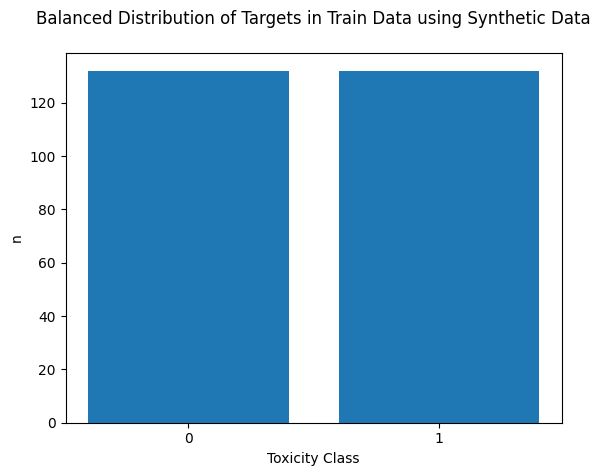

In [20]:
# Visualization of balanced data frequency
plot_values = y_train.value_counts(ascending = False)
fig, ax = plt.subplots()

ax.bar(x = ['0', '1'], height = plot_values.array)

plt.title('Balanced Distribution of Targets in Train Data using Synthetic Data\n')
plt.xlabel('Toxicity Class')
plt.ylabel('n')
plt.show()

# StandardScaler and TargetEncoder

In [21]:
# Pre-processing of the numerical features using a StandardScaler
scaler = StandardScaler()

numerical_columns = ['BMI', 'AgeAtCompletion', 'TreatmentDays', 'V100', 'D50', 'D90', 'D98', 'D0.1Bladder', 'D1Bladder',
    'D2Bladder', 'D0.1SmallBowel', 'D1SmallBowel', 'D2SmallBowel',
    'D0.1Sigmoid', 'D1Sigmoid', 'D2Sigmoid','D0.1Rectum', 'D1Rectum', 'D2Rectum',
    'Size', 'HRCTVolume', 'FollowUp']

categorical_columns = ['Chemotherapy', 'Charlson', 'KPS', 'Ethnicity', 'TypeOfBoost', 'Applicator', 'MRI', 
    'TumorSite', 'Stage', 'Histology']

X_imputed_train_df[numerical_columns] = scaler.fit_transform(X_imputed_train_df[numerical_columns])

# Save the fitted StandardScaler using joblib
joblib.dump(scaler, scaler_filename)

['C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/scaler']

In [22]:
# Initialize the TargetEncoder
target_encoder = TargetEncoder(cols = categorical_columns)

# Fit and transform the categorical variables
X_imputed_train_df[categorical_columns] = target_encoder.fit_transform(X_imputed_train_df[categorical_columns], y_train)

# Save the fitted TargetEncoder
joblib.dump(target_encoder, encoder_filename)

['C:/Users/bonif/OneDrive/Documentos/Final DB HDR/Final/UseThis/encoder']

# Drop Collinear Features

In [23]:
# Find collinear features using Pearson Correlation Coefficient
# Oversampling was done before collinearity analysis in order to replicate real data as closely as possible.

corr_matrix = X_imputed_train_final.corr().abs()

# Pick up the upper triangle of our co-linearity matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

print(upper)

                 Chemotherapy       BMI  Charlson       KPS  Ethnicity  \
Chemotherapy              NaN  0.039809  0.184585  0.152763   0.034584   
BMI                       NaN       NaN  0.091671  0.001748   0.013407   
Charlson                  NaN       NaN       NaN  0.192269   0.043786   
KPS                       NaN       NaN       NaN       NaN   0.157835   
Ethnicity                 NaN       NaN       NaN       NaN        NaN   
AgeAtCompletion           NaN       NaN       NaN       NaN        NaN   
TypeOfBoost               NaN       NaN       NaN       NaN        NaN   
TreatmentDays             NaN       NaN       NaN       NaN        NaN   
Applicator                NaN       NaN       NaN       NaN        NaN   
MRI                       NaN       NaN       NaN       NaN        NaN   
V100                      NaN       NaN       NaN       NaN        NaN   
D50                       NaN       NaN       NaN       NaN        NaN   
D90                       NaN       Na

In [24]:
# Find features with correlation greater than 0.80 and store them in a List
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Print the variables that are co-linear
print(to_drop)

['D98', 'D1Bladder', 'D2Bladder', 'D1SmallBowel', 'D2SmallBowel', 'D1Sigmoid', 'D2Sigmoid', 'D1Rectum', 'D2Rectum']


In [25]:
# OPTIONAL: Print the co-lineariaty values for the variable you are planning to drop to see which variables it is co-linear with
print(corr_matrix[['D98']]) 

                      D98
Chemotherapy     0.023134
BMI              0.046095
Charlson         0.124557
KPS              0.080246
Ethnicity        0.046891
AgeAtCompletion  0.118207
TypeOfBoost      0.100733
TreatmentDays    0.171353
Applicator       0.051843
MRI              0.106720
V100             0.020743
D50              0.678727
D90              0.956844
D98              1.000000
D0.1Bladder      0.100222
D1Bladder        0.271262
D2Bladder        0.324251
D0.1SmallBowel   0.268554
D1SmallBowel     0.312825
D2SmallBowel     0.337004
D0.1Sigmoid      0.298673
D1Sigmoid        0.368893
D2Sigmoid        0.389815
D0.1Rectum       0.310433
D1Rectum         0.367628
D2Rectum         0.379939
TumorSite        0.002137
Stage            0.033096
Histology        0.018398
Size             0.076481
HRCTVolume       0.162930
FollowUp         0.196718


In [26]:
# Determine which co-linear variables are appropiate to drop
to_drop = ['D98','D1Bladder','D0.1SmallBowel', 'D1SmallBowel','D1Sigmoid', 'D0.1Rectum', 'D1Rectum']  

In [27]:
# Drop features for TRAINING set
X_imputed_train_df = X_imputed_train_df.drop(to_drop, axis=1, inplace=False)

# Print Final DB Columns
X_imputed_train_df.columns.tolist()

['Chemotherapy',
 'BMI',
 'Charlson',
 'KPS',
 'Ethnicity',
 'AgeAtCompletion',
 'TypeOfBoost',
 'TreatmentDays',
 'Applicator',
 'MRI',
 'V100',
 'D50',
 'D90',
 'D0.1Bladder',
 'D2Bladder',
 'D2SmallBowel',
 'D0.1Sigmoid',
 'D2Sigmoid',
 'D2Rectum',
 'TumorSite',
 'Stage',
 'Histology',
 'Size',
 'HRCTVolume',
 'FollowUp']

In [28]:
# Check the variance for remaining columns. Variance close to 0 means values are almost constant and may be considered to be dropped.
X_imputed_train_df.var(0)

Chemotherapy       0.001236
BMI                1.003802
Charlson           0.027248
KPS                0.003201
Ethnicity          0.000618
AgeAtCompletion    1.003802
TypeOfBoost        0.011197
TreatmentDays      1.003802
Applicator         0.005523
MRI                0.015136
V100               1.003802
D50                1.003802
D90                1.003802
D0.1Bladder        1.003802
D2Bladder          1.003802
D2SmallBowel       1.003802
D0.1Sigmoid        1.003802
D2Sigmoid          1.003802
D2Rectum           1.003802
TumorSite          0.000751
Stage              0.017475
Histology          0.005096
Size               1.003802
HRCTVolume         1.003802
FollowUp           1.003802
dtype: float64

# Load external instances (optional)

In [29]:
# Load all fitted transformers - if needed
imputer_categorical = joblib.load(cat_imputer_filename)

imputer_numerical = joblib.load(num_imputer_filename)

scaler = joblib.load(scaler_filename)

target_encoder = joblib.load(encoder_filename)

# Preparing datasets for final fit

In [30]:
# Transform the numerical columns in the assesment training data (unbalanced)
X_imputed_train_final[numerical_columns] = scaler.transform(X_imputed_train_final[numerical_columns])

# Apply the TargetEncoder to the categorical columns in the assesment training data (unbalanced)
X_imputed_train_final[categorical_columns] = target_encoder.transform(X_imputed_train_final[categorical_columns])

# Drop features for the assesment training data (unbalanced)
X_imputed_train_final = X_imputed_train_final.drop(to_drop, axis = 1, inplace = False)

In [31]:
# Preprocess test data with the previously fitted transformers 
X_test[categorical_columns] = imputer_categorical.transform(X_test)[ : , categorical_columns_index]
X_imputed_test = imputer_numerical.transform(X_test)

X_imputed_test_df = pd.DataFrame(X_imputed_test, columns = X_test.columns)
X_imputed_test_df.index = y_test.index

X_imputed_test_df[numerical_columns] = scaler.transform(X_imputed_test_df[numerical_columns])
X_imputed_test_df[categorical_columns] = target_encoder.transform(X_imputed_test_df[categorical_columns])

# Drop features for the Testing data
X_imputed_test_df = X_imputed_test_df.drop(to_drop, axis = 1, inplace = False)

In [32]:
# Counting NaN values in final datasets
nan_count_assesment = X_imputed_train_final.isna().sum()
print("\033[1m" + "Missing Values for Each Column in Final Training Set\n" + "\033[0m")
print(nan_count_assesment)

nan_count = X_imputed_test_df.isna().sum()
print("\n\033[1m" + "Missing Values for Each Column in Testing Set\n" + "\033[0m")
print(nan_count)

Missing Values for Each Column in Final Training Set

Chemotherapy       0
BMI                0
Charlson           0
KPS                0
Ethnicity          0
AgeAtCompletion    0
TypeOfBoost        0
TreatmentDays      0
Applicator         0
MRI                0
V100               0
D50                0
D90                0
D0.1Bladder        0
D2Bladder          0
D2SmallBowel       0
D0.1Sigmoid        0
D2Sigmoid          0
D2Rectum           0
TumorSite          0
Stage              0
Histology          0
Size               0
HRCTVolume         0
FollowUp           0
dtype: int64

Missing Values for Each Column in Testing Set

Chemotherapy       0
BMI                0
Charlson           0
KPS                0
Ethnicity          0
AgeAtCompletion    0
TypeOfBoost        0
TreatmentDays      0
Applicator         0
MRI                0
V100               0
D50                0
D90                0
D0.1Bladder        0
D2Bladder          0
D2SmallBowel       0
D0.1Sigmoid        0
D2S

In [33]:
# Changing the format of our Y label so that it is compatible with the Sequential Feature Selection method.
labels_test = np.ravel(y_test)
labels_train = np.ravel(y_train)

# Hyperparameter Tuning

## Logistic Regression

In [34]:
# Instances
lr1 = LogisticRegression(random_state = 42, max_iter = 250)
lr2 = LogisticRegression(random_state = 42, max_iter = 250)

# Sequential Feature Selection
sfsLR = SFS(estimator = lr1, 
    k_features = 'best',
    forward = True, 
    floating = False, 
    scoring = 'f1',
    cv = sss)

# Pipeline
pipe_lr = Pipeline([
    ('lr2', lr2)])

# Hyperparameters to explore
param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1]

lr_param_grid = [{'lr2__penalty': ['l1', 'l2'],
    'lr2__C': param_range_fl,
    'lr2__solver': ['liblinear','lbfgs']}]

# Gridsearch will use the parameters defined on param_grids to find the best Hyper-Parameter for the model.
lr_grid_search = GridSearchCV(estimator = pipe_lr,
    param_grid = lr_param_grid,
    scoring = 'f1',
    cv = sss)

## Random Forest

In [35]:
# Instances
rf2 = RandomForestClassifier(random_state = 42)

# SFS placeholder - needed for "zip" function used to calculate metrics afterwards
sfsRF = 'placeholder'

# Pipeline
pipe_rf = Pipeline([
    ('rf2', rf2)])

# Hyperparameters to explore
param_range_rf = [5, 6, 7, 8, 9, 10]
param_estimators_rf = [10, 15, 20, 25, 30, 35, 40, 45, 50,100,200]
param_max_features = ['sqrt', 'log2']

rf_param_grid = [{'rf2__min_samples_leaf': param_range_rf,
        'rf2__n_estimators': param_estimators_rf,
        'rf2__min_samples_split': param_range_rf,
        'rf2__max_features': param_max_features}]

# Gridsearch will use the parameters defined on param_grids to find the best Hyper-Parameter for the model.
rf_grid_search = GridSearchCV(estimator = pipe_rf,     
    param_grid = rf_param_grid,
    scoring = 'f1',
    cv = sss)

## K-Nearest Neighbors

In [36]:
# Instances
knn1 = KNeighborsClassifier()
knn2 = KNeighborsClassifier()

# Sequential Feature Selection
sfsKNN = SFS(estimator = knn1, 
    k_features = 'best',
    forward = True, 
    floating = False, 
    scoring = 'f1',
    cv = sss)

# Pipeline
pipe_knn = Pipeline([
    ('knn2', knn2)])

# Hyperparameters to explore
param_range_knn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

knn_param_grid = [{'knn2__n_neighbors': param_range_knn}]

# Gridsearch will use the parameters defined on param_grids to find the best Hyper-Parameter for the model.
knn_grid_search = GridSearchCV(estimator = pipe_knn,
    param_grid = knn_param_grid,
    scoring = 'f1',
    cv = sss)

## Support Vector Machines

In [37]:
# Instances
svm1 = SVC(random_state = 42, probability = True)
svm2 = SVC(random_state = 42, probability = True)

# Sequential Feature Selection
sfsSVM = SFS(estimator = svm1, 
    k_features = 'best',
    forward = True, 
    floating = False, 
    scoring = 'f1',
    cv = sss)

# Pipeline
pipe_svm = Pipeline([
    ('svm2',svm2)])

# Hyperparameters to explore
param_range_svm = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

svm_param_grid = [{'svm2__kernel': ['linear', 'rbf','poly','sigmoid'],
    'svm2__gamma': ['scale', 'auto'], 
    'svm2__C': param_range_svm}]

# Gridsearch will use the parameters defined on param_grids to find the best Hyper-Parameter for the model.
svm_grid_search = GridSearchCV(estimator = pipe_svm,
    param_grid = svm_param_grid,
    scoring = 'f1',
    cv = sss)

## Gaussian Naive Bayes

In [38]:
# Instances
gnb1 = GaussianNB()
gnb2 = GaussianNB()

# Sequential Feature Selection
sfsGNB = SFS(estimator = gnb1, 
    k_features = 'best',
    forward = True, 
    floating = False, 
    scoring = 'f1',
    cv = sss)

# Pipeline
pipe_gnb = Pipeline([
    ('gnb2',gnb2)])

# Hyperparameters to explore
var_smoothingNumbers=[5e-08, 1e-09, 5e-09]

gnb_param_grid = [{'gnb2__var_smoothing': var_smoothingNumbers}]

# Gridsearch will use the parameters defined on param_grids to find the best Hyper-Parameter for the model.
gnb_grid_search = GridSearchCV(estimator = pipe_gnb,
    param_grid = gnb_param_grid,
    scoring = 'f1',
    cv = sss)

## MultiLayer Perceptron

In [39]:
# Instances
mlp2 = MLPClassifier(hidden_layer_sizes = (16,8), random_state = 42) 

# SFS placeholder - needed for "zip" function used to calculate metrics afterwards
sfsMLP = 'placeholder'

# Pipeline
pipe_mlp = Pipeline([
    ('mlp2', mlp2)])

# Hyperparameters to explore
learning_rates = [0.001, .1, .15, .2, .3, .5, 1]
MLPalpha=[0.0001, 0.0005, 0.001]
MLPbatchsize=[20, 32, 50]
MLPtols=[0.00001, 0.0001, 0.0005]

mlp_param_grid = [{ 'mlp2__learning_rate': ['constant', 'invscaling','adaptive'],
    'mlp2__activation': ['logistic', 'tanh', 'relu'],
    'mlp2__solver': ['lbfgs', 'sgd'],
    'mlp2__learning_rate_init': learning_rates,
    'mlp2__alpha': MLPalpha,
    'mlp2__batch_size': MLPbatchsize,
    'mlp2__tol': MLPtols}]

# Gridsearch will use the parameters defined on param_grids to find the best Hyper-Parameter for the model.
mlp_grid_search = GridSearchCV(estimator = pipe_mlp,     
    param_grid = mlp_param_grid,
    scoring = 'f1',
    cv = sss)

## XGBoost

In [40]:
# Instance: XGBoost classifier with default parameters; 
# use_label_encoder=False and eval_metric are set to avoid warnings.
xgb = XGBClassifier(random_state=42)

# SFS placeholder - needed for "zip" function used to calculate metrics afterwards
sfsXGB = 'placeholder'

# Pipeline
pipe_xgb = Pipeline([
    ('xgb', xgb)
])

# Hyperparameters to explore
# Note: The search space is designed considering a small dataset. 
# For instance, max_depth is kept low and n_estimators moderate.
xgb_param_grid = [{
    'xgb__max_depth': [1, 2, 3, 4],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [75, 100, 125],
    'xgb__subsample': [0.5, 0.75, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0],
    'xgb__gamma': [0, 0.1, 0.2]
}]

# GridSearchCV will use the parameters defined in xgb_param_grid to find the best hyper-parameters.
# 'sss' should be a cross-validation generator such as StratifiedShuffleSplit defined elsewhere.
xgb_grid_search = GridSearchCV(estimator=pipe_xgb,     
                               param_grid=xgb_param_grid,
                               scoring='f1',
                               cv=sss)


# GridSearch Exploration

In [41]:
# Models we are exploring
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2: 'K-Nearest Neighbors',
3: 'Support Vector Machines', 4: 'Gaussian Naive Bayes', 5: 'Multi-Layer Perceptron', 6: 'XGBoost'}

grids = [lr_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, gnb_grid_search, mlp_grid_search, xgb_grid_search]

SFSList = [sfsLR, sfsRF, sfsKNN, sfsSVM, sfsGNB, sfsMLP, sfsXGB]

total_time_start = time.time()

j = 0
for pipe, sfs in zip(grids, SFSList):
    
    if sfs == sfsLR or sfs == sfsKNN or sfs == sfsSVM or sfs == sfsGNB:
        
        model_time_start = time.time()
        
        # Fit the SFS to the balanced Train data [This will also update the SFSList items]
        sfs = sfs.fit(X_imputed_train_df, labels_train)

        # Get selected feature indices
        selected_feature_indices = list(sfs.k_feature_idx_)

        # Create a pandas DataFrame with selected features
        sfsFinal = X_imputed_train_df.iloc[:, selected_feature_indices]

        # Rename columns to original feature names
        sfsFinal.columns = X_imputed_train_df.columns[selected_feature_indices]

        # Perform the GridSearch
        pipe.fit(sfsFinal, labels_train)

        print(f'Finished {grid_dict[j]} -> {(time.time() - model_time_start)/60} m' )
        j += 1
        
    else:

        model_time_start = time.time()
        
        # Perform the GridSearch
        pipe.fit(X_imputed_train_df, labels_train)

        print(f'Finished {grid_dict[j]} -> {(time.time() - model_time_start)/60} m' )
        j += 1

print(f'Total time -> {(time.time() - total_time_start)/60} m' )

Finished Logistic Regression -> 0.349309245745341 m
Finished Random Forest -> 8.238890071709951 m
Finished K-Nearest Neighbors -> 0.45054735740025836 m
Finished Support Vector Machines -> 0.7255690296490988 m
Finished Gaussian Naive Bayes -> 0.12868864536285402 m
Finished Multi-Layer Perceptron -> 104.32802922725678 m
Finished XGBoost -> 28.860351912180583 m
Total time -> 143.08138548930486 m


# Final Model Training

In [42]:
# Using the best hyperparameters from GridSearch, the final model is fitted for each algorithm
for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    
    if sfsItem == sfsLR or sfsItem == sfsKNN or sfsItem == sfsSVM or sfsItem == sfsGNB:
       
        print(f'----- {grid_dict[i]} -----')
        
        # Get the indices of selected features 
        selected_feature_indices = list(sfsItem.k_feature_idx_)
        
        print(f'Best Hyper Parameters -> {model.best_params_}')
        print(f'SFS F1 Score -> {sfsItem.k_score_}')
        print(f'SFS Feature Names -> {sfsItem.k_feature_names_}')
        print(f'Score for Trained Tuned model -> {model.best_score_}\n') 
        
        # Create a pandas DataFrame with selected features
        X_train_selected = X_imputed_train_final.iloc[:, selected_feature_indices]
        X_test_selected = X_imputed_test_df.iloc[:, selected_feature_indices]
       
        # Calculate various metrics
        y_pred_train = model.predict(X_train_selected)
        y_pred_test = model.predict(X_test_selected)
    
        f1_train = f1_score(y_train_final, y_pred_train)
        normMCC_train = (1 + matthews_corrcoef(y_train_final, y_pred_train)) / 2.
        accuracy_train = accuracy_score(y_train_final, y_pred_train)
        precision_train = precision_score(y_train_final, y_pred_train)
        recall_train = recall_score(y_train_final, y_pred_train)

        print(f'Train Data F1 Score -> {f1_train}')
        print(f'Train Data normMCC -> {normMCC_train}')
        print(f'Train Data Accuracy -> {accuracy_train}')
        print(f'Train Data Precision -> {precision_train}')
        print(f'Train Data Recall -> {recall_train}\n')
        
        f1_test = f1_score(labels_test, y_pred_test)
        normMCC_test = (1 + matthews_corrcoef(labels_test, y_pred_test)) / 2.
        accuracy_test = accuracy_score(labels_test, y_pred_test)
        precision_test = precision_score(labels_test, y_pred_test)
        recall_test = recall_score(labels_test, y_pred_test)

        print(f'Test Data F1 Score -> {f1_test}')
        print(f'Test Data normMCC -> {normMCC_test}')
        print(f'Test Data Accuracy -> {accuracy_test}')
        print(f'Test Data Precision -> {precision_test}')
        print(f'Test Data Recall -> {recall_test}\n')

        # Calculate AUC-ROC and AUC-PR scores
        fpr_train, tpr_train, _ = roc_curve(y_train_final, model.predict_proba(X_train_selected)[:, 1])
        auc_roc_train = auc(fpr_train, tpr_train)

        precision_train, recall_train, _ = precision_recall_curve(y_train_final, model.predict_proba(X_train_selected)[:, 1])
        auc_pr_train = auc(recall_train, precision_train)

        print(f'Train Data AUC-ROC Score -> {auc_roc_train}')
        print(f'Train Data AUC-PR Score- > {auc_pr_train}\n')
        
        fpr_test, tpr_test, _ = roc_curve(labels_test, model.predict_proba(X_test_selected)[:, 1])
        auc_roc_test = auc(fpr_test, tpr_test)

        precision_test, recall_test, _ = precision_recall_curve(labels_test, model.predict_proba(X_test_selected)[:, 1])
        auc_pr_test = auc(recall_test, precision_test)

        print(f'Test Data AUC-ROC Score -> {auc_roc_test}')
        print(f'Test Data AUC-PR Score- > {auc_pr_test}')
        print('\n')
        
    else:
        
        print(f'----- {grid_dict[i]} -----')

        # Print best hyperparameters for MLP and RF
        print(f'Best Hyper Parameters -> {model.best_params_}')
        print(f'Score for Trained Tuned model -> {model.best_score_}\n') 
        
        # Rename final sets for code consistency
        X_train_selected = X_imputed_train_final
        X_test_selected = X_imputed_test_df
        
        # Calculate various metrics
        y_pred_train = model.predict(X_train_selected)
        y_pred_test = model.predict(X_test_selected)
    
        f1_train = f1_score(y_train_final, y_pred_train)
        normMCC_train = (1 + matthews_corrcoef(y_train_final, y_pred_train)) / 2.
        accuracy_train = accuracy_score(y_train_final, y_pred_train)
        precision_train = precision_score(y_train_final, y_pred_train)
        recall_train = recall_score(y_train_final, y_pred_train)

        print(f'Train Data F1 Score -> {f1_train}')
        print(f'Train Data normMCC -> {normMCC_train}')
        print(f'Train Data Accuracy -> {accuracy_train}')
        print(f'Train Data Precision -> {precision_train}')
        print(f'Train Data Recall -> {recall_train}\n')
        
        f1_test = f1_score(labels_test, y_pred_test)
        normMCC_test = (1 + matthews_corrcoef(labels_test, y_pred_test)) / 2.
        accuracy_test = accuracy_score(labels_test, y_pred_test)
        precision_test = precision_score(labels_test, y_pred_test)
        recall_test = recall_score(labels_test, y_pred_test)

        print(f'Test Data F1 Score -> {f1_test}')
        print(f'Test Data normMCC -> {normMCC_test}')
        print(f'Test Data Accuracy -> {accuracy_test}')
        print(f'Test Data Precision -> {precision_test}')
        print(f'Test Data Recall -> {recall_test}\n')

        # Calculate AUC-ROC and AUC-PR scores
        fpr_train, tpr_train, _ = roc_curve(y_train_final, model.predict_proba(X_train_selected)[:, 1])
        auc_roc_train = auc(fpr_train, tpr_train)

        precision_train, recall_train, _ = precision_recall_curve(y_train_final, model.predict_proba(X_train_selected)[:, 1])
        auc_pr_train = auc(recall_train, precision_train)

        print(f'Train Data AUC-ROC Score -> {auc_roc_train}')
        print(f'Train Data AUC-PR Score- > {auc_pr_train}\n')
        
        fpr_test, tpr_test, _ = roc_curve(labels_test, model.predict_proba(X_test_selected)[:, 1])
        auc_roc_test = auc(fpr_test, tpr_test)

        precision_test, recall_test, _ = precision_recall_curve(labels_test, model.predict_proba(X_test_selected)[:, 1])
        auc_pr_test = auc(recall_test, precision_test)

        print(f'Test Data AUC-ROC Score -> {auc_roc_test}')
        print(f'Test Data AUC-PR Score- > {auc_pr_test}')
        print('\n')


----- Logistic Regression -----
Best Hyper Parameters -> {'lr2__C': 1.0, 'lr2__penalty': 'l2', 'lr2__solver': 'lbfgs'}
SFS F1 Score -> 0.8058071575779342
SFS Feature Names -> ('Chemotherapy', 'Charlson', 'KPS', 'Ethnicity', 'TypeOfBoost', 'Applicator', 'D2SmallBowel', 'D2Rectum', 'TumorSite', 'Stage', 'Histology', 'FollowUp')
Score for Trained Tuned model -> 0.8058071575779342

Train Data F1 Score -> 0.45
Train Data normMCC -> 0.6434790051561212
Train Data Accuracy -> 0.7471264367816092
Train Data Precision -> 0.47368421052631576
Train Data Recall -> 0.42857142857142855

Test Data F1 Score -> 0.5217391304347826
Test Data normMCC -> 0.7141057445312242
Test Data Accuracy -> 0.8135593220338984
Test Data Precision -> 0.6666666666666666
Test Data Recall -> 0.42857142857142855

Train Data AUC-ROC Score -> 0.7198773448773449
Train Data AUC-PR Score- > 0.4324848236414806

Test Data AUC-ROC Score -> 0.6761904761904762
Test Data AUC-PR Score- > 0.4685494593852829


----- Random Forest -----
Best

# Plot Precision-Recall Curve

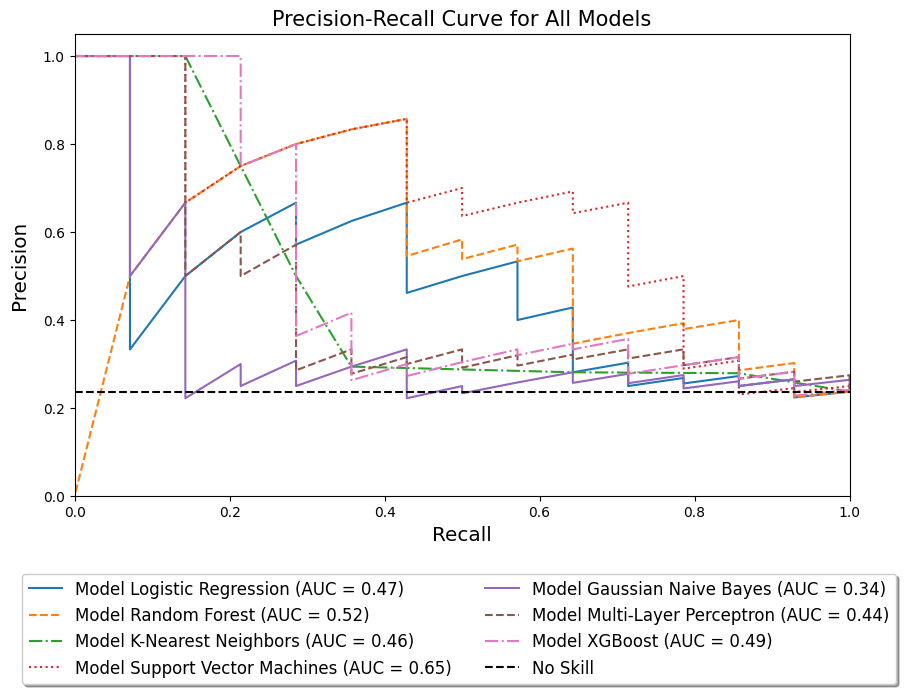

In [43]:
# Create a list to store the selected features for each model
X_test_selected_list = []

for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    
    if sfsItem == sfsLR or sfsItem == sfsKNN or sfsItem == sfsSVM or sfsItem == sfsGNB:
        # Get the indices of selected features from the current SFS object
        selected_feature_indices = list(sfsItem.k_feature_idx_)

        # Create a pandas DataFrame with selected features
        X_test_selected = X_imputed_test_df.iloc[:, selected_feature_indices]

        # Append X_test_selected to the list
        X_test_selected_list.append(X_test_selected)
    else:
        # Rename final set for code consistency
        X_test_selected = X_imputed_test_df

        # Append X_test_selected to the list
        X_test_selected_list.append(X_test_selected)

# Calculate the "No Skill" line based on your data
no_skill = len(labels_test[labels_test == 1]) / len(labels_test)
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# Plot the Precision-Recall curves for all models
plt.figure(figsize=(10, 6))
for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    precision, recall, _ = precision_recall_curve(labels_test, model.predict_proba(X_test_selected_list[i])[:, 1])
    
    # Calculate AUC
    auc_pr = auc(recall, precision)
    
    # Cycle through line styles using modulo operator
    linestyle = line_styles[i % len(line_styles)]
    
    plt.plot(recall, precision, label='Model {} (AUC = {:.2f})'.format(grid_dict[i], auc_pr), linestyle=linestyle)

# Plot the "No Skill" line
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')

plt.xlabel('Recall', fontsize='x-large')
plt.ylabel('Precision', fontsize='x-large',labelpad=10)
plt.title('Precision-Recall Curve for All Models', fontsize=15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Plot formatting
plt.legend(loc='upper center', bbox_to_anchor=(0.496, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='large')

plt.show()

# Plot ROC Curve

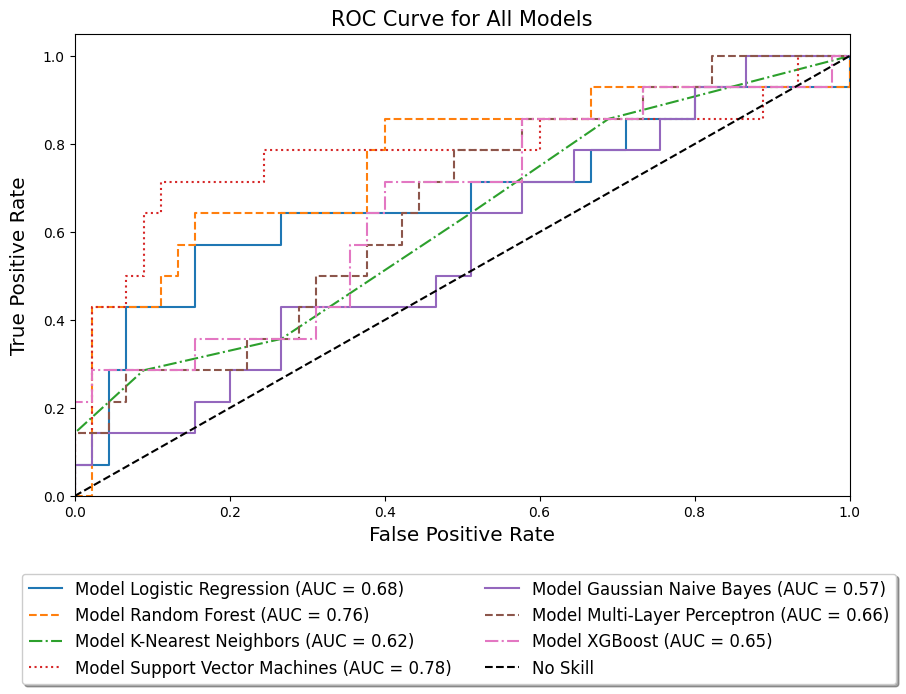

In [44]:
from sklearn.metrics import roc_curve, auc

# Create a list to store the selected features for each model
X_test_selected_list = []

for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    
    if sfsItem == sfsLR or sfsItem == sfsKNN or sfsItem == sfsSVM or sfsItem == sfsGNB:
        # Get the indices of selected features from the current SFS object
        selected_feature_indices = list(sfsItem.k_feature_idx_)

        # Create a pandas DataFrame with selected features
        X_test_selected = X_imputed_test_df.iloc[:, selected_feature_indices]

        # Append X_test_selected to the list
        X_test_selected_list.append(X_test_selected)
    else:
        # Rename final set for code consistency
        X_test_selected = X_imputed_test_df

        # Append X_test_selected to the list
        X_test_selected_list.append(X_test_selected)

# Calculate the "No Skill" line based on your data
no_skill = len(labels_test[labels_test == 1]) / len(labels_test)
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# Plot the ROC curves for all models
plt.figure(figsize=(10, 6))
for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    fpr, tpr, _ = roc_curve(labels_test, model.predict_proba(X_test_selected_list[i])[:, 1])
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    
    # Cycle through line styles using modulo operator
    linestyle = line_styles[i % len(line_styles)]
    
    plt.plot(fpr, tpr, label='Model {} (AUC = {:.2f})'.format(grid_dict[i], roc_auc), linestyle=linestyle)

# Plot the "No Skill" line
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='No Skill')

plt.xlabel('False Positive Rate', fontsize='x-large')
plt.ylabel('True Positive Rate', fontsize='x-large',labelpad=10)
plt.title('ROC Curve for All Models', fontsize=15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Plot formatting
plt.legend(loc='upper center', bbox_to_anchor=(0.496, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='large')

plt.show()

Using 174 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Calculating SHAP values for Support Vector Machines (SVM)
Creating KernelExplainer (this may take some time)...
Computing SHAP values for the test set...


  0%|          | 0/59 [00:00<?, ?it/s]

Plotting SHAP summary for Support Vector Machines...


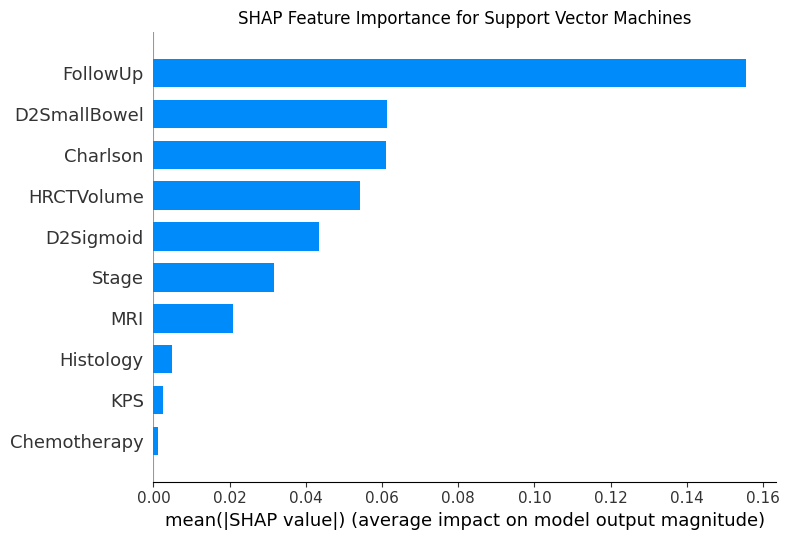

In [45]:
import shap
import matplotlib.pyplot as plt
import numpy as np

for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    model_name = grid_dict[i]
    if model_name != "Support Vector Machines":
        continue  # Skip models that are not SVM
    
    print(f"\nCalculating SHAP values for {model_name} (SVM)")
    
    # Determine the selected features based on Sequential Feature Selection
    if sfsItem == sfsSVM:
        selected_feature_indices = list(sfsItem.k_feature_idx_)
        X_train_selected = X_imputed_train_final.iloc[:, selected_feature_indices]
        X_test_selected = X_imputed_test_df.iloc[:, selected_feature_indices]
    
    # Access the trained SVM model within the pipeline
    svm_model = model.best_estimator_.named_steps['svm2']
    
    # Use KernelExplainer for SVM
    print("Creating KernelExplainer (this may take some time)...")
    explainer = shap.KernelExplainer(svm_model.predict_proba, X_train_selected)
    
    # Compute SHAP values for the test set
    print("Computing SHAP values for the test set...")
    shap_values = explainer.shap_values(X_test_selected)
    
    # For binary classification, select the SHAP values for the positive class
    # The shape is (n_samples, n_features, n_classes)
    # We want the column for the positive class (typically index 1)
    shap_values_to_plot = shap_values[:, :, 1]
    
    # Plot SHAP summary plot
    print(f"Plotting SHAP summary for {model_name}...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_to_plot, 
        X_test_selected, 
        feature_names=X_test_selected.columns, 
        plot_type='bar', 
        max_display=30, 
        show=False
    )
    plt.title(f"SHAP Feature Importance for {model_name}")
    plt.tight_layout()
    plt.show()
    



Generating Variable Importance Plot for Random Forest (Random Forest)


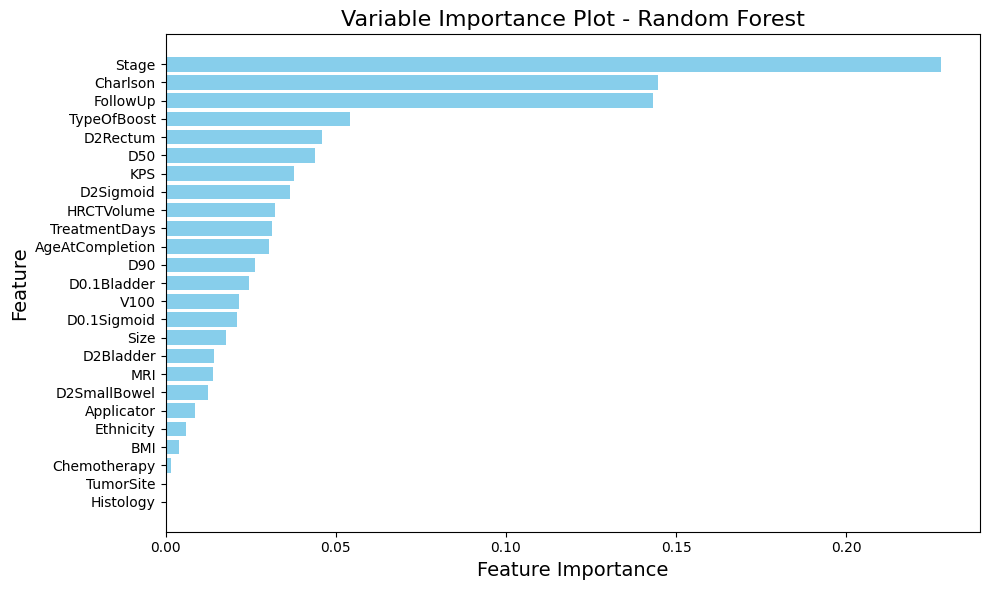

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Access the trained Random Forest model
for i, model in enumerate(grids):
    model_name = grid_dict[i]
    if model_name != "Random Forest":
        continue  # Skip models that are not Random Forest

    print(f"\nGenerating Variable Importance Plot for {model_name} (Random Forest)")

    # Access the trained Random Forest model within the pipeline
    rf_model = model.best_estimator_.named_steps['rf2']

    # Compute feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X_imputed_train_final.columns  # Use all features from the training dataset

    # Create a DataFrame for better visualization
    varimp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot the VarImp chart
    plt.figure(figsize=(10, 6))
    plt.barh(varimp_df['Feature'], varimp_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title('Variable Importance Plot - Random Forest', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.tight_layout()
    plt.show()



Calculating SHAP values for Logistic Regression (LR)
Creating LinearExplainer...
Computing SHAP values for the test set...
Plotting SHAP summary for Logistic Regression...


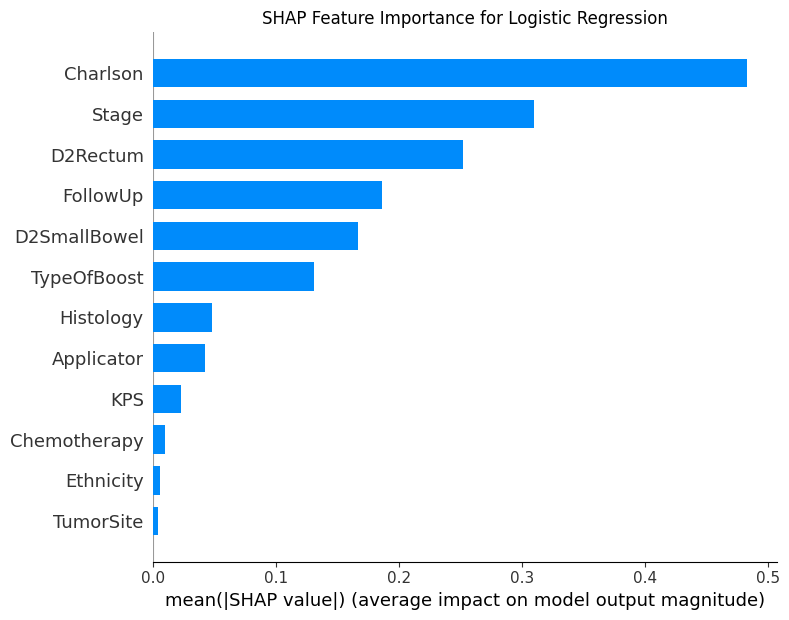

In [47]:
import shap
import matplotlib.pyplot as plt
import numpy as np

for i, (sfsItem, model) in enumerate(zip(SFSList, grids)):
    model_name = grid_dict[i]
    if model_name != "Logistic Regression":
        continue  # Skip models that are not Logistic Regression
    
    print(f"\nCalculating SHAP values for {model_name} (LR)")
    
    # Determine the selected features based on Sequential Feature Selection
    if sfsItem == sfsLR:
        selected_feature_indices = list(sfsItem.k_feature_idx_)
        X_train_selected = X_imputed_train_final.iloc[:, selected_feature_indices]
        X_test_selected = X_imputed_test_df.iloc[:, selected_feature_indices]
    
    # Access the trained Logistic Regression model within the pipeline
    lr_model = model.best_estimator_.named_steps['lr2']
    
    # Use LinearExplainer for Logistic Regression
    print("Creating LinearExplainer...")
    explainer = shap.LinearExplainer(lr_model, X_train_selected)
    
    # Compute SHAP values for the test set
    print("Computing SHAP values for the test set...")
    shap_values = explainer.shap_values(X_test_selected)
    
    # Since it's binary classification, shap_values is an array
    shap_values_to_plot = shap_values
    
    # Plot SHAP summary plot
    print(f"Plotting SHAP summary for {model_name}...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_to_plot, 
        X_test_selected, 
        feature_names=X_test_selected.columns, 
        plot_type='bar', 
        max_display=30, 
        show=False
    )
    plt.title(f"SHAP Feature Importance for {model_name}")
    plt.tight_layout()
    plt.show()
